In [2]:
import quimb.tensor as qtn
import torch
from vmc_torch.fermion_utils import *
L = 10
D = 4

In [3]:
random_mps = qtn.MPS_rand_state(L=L, bond_dim=D, cyclic=False)
random_mps.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float64))

In [4]:
ham = qtn.ham_1d_heis(L, j=1.0, cyclic=False)
ham.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float64))

In [5]:
random_mps.compute_local_expectation_exact(ham.terms, normalized=True)

tensor(-0.8072, dtype=torch.float64)

In [16]:
import quimb as qu
ham_quimb = qu.ham_heis(L, j=1.0)
qu.groundenergy(ham_quimb)
ham_quimb.toarray()

array([[2.25, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 1.75, 0.5 , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 1.25, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 1.25, 0.5 , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.5 , 1.75, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 2.25]], shape=(1024, 1024))

In [21]:
su = qtn.SimpleUpdateGen(
    random_mps,
    ham,
    D=D,
    second_order_reflect=True,
    compute_energy_every=25,
    compute_energy_fn = lambda su: su.get_state().compute_local_expectation_exact(ham.terms, normalized=True),
    plot_every=10,
)

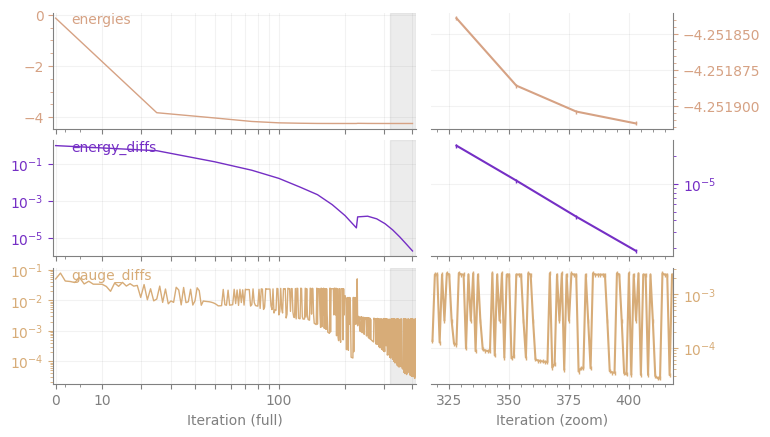

n=428, D=4, tau=0.01, max|dS|=2.36e-05, energy≈-4.25192: 100%|##########| 200/200 [00:10<00:00, 17.00it/s]

In [ ]:
su.evolve(200, tau=0.1)
su.evolve(200, tau=0.05)
su.evolve(200, tau=0.01)

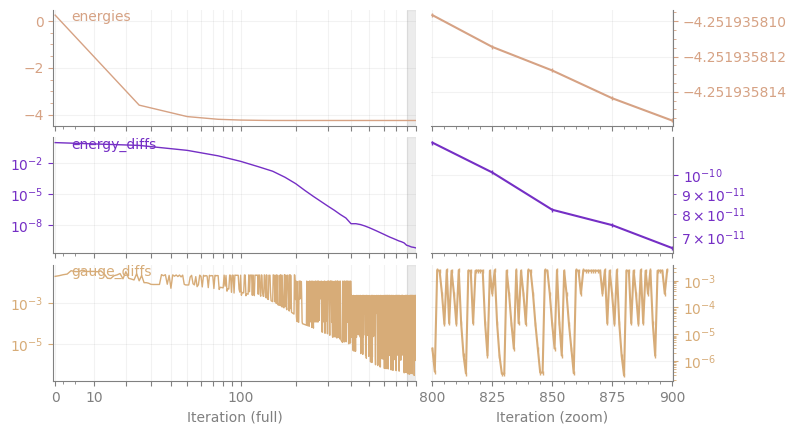

n=900, D=4, tau=0.01, max|dS|=0.00244, energy≈-4.25194: 100%|##########| 300/300 [00:16<00:00, 18.48it/s]


In [ ]:
su.evolve(300, tau=0.01)

In [ ]:
import pickle
su.assemble_plot_data()
with open(f"circuitTNF_heis_L{L}_D{D}_plot.pkl", "wb") as f:
    pickle.dump(su.assemble_plot_data(), f)
with open(f"circuitTNF_heis_L{L}_D{D}_su_state.pkl", "wb") as f:
    params, skeleton = qtn.pack(su.get_state())
    pickle.dump((params, skeleton), f)

In [ ]:
qu.ham_heis(L, j=1.0)

In [17]:
from vmc_torch.experiment.tn_model import circuit_TNF
from vmc_torch.sampler import MetropolisExchangeSamplerSpinless
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import SGD, SR, DecayScheduler
from vmc_torch.VMC import VMC
from vmc_torch.hamiltonian_torch import spin_Heisenberg_chain_torch
from vmc_torch.torch_utils import SVD,QR

import pickle
su_params, su_skeleton = pickle.load(open("circuitTNF_heis_L10_D6_su_state.pkl", "rb"))
su_mps = qtn.unpack(su_params, su_skeleton)
circuit_tnf = circuit_TNF(
    su_mps,
    ham,
    trotter_tau=0.01,
    depth=4
)


In [73]:
from vmc_torch.hamiltonian_torch import spin_Heisenberg_chain_torch
from funcs import *
H = spin_Heisenberg_chain_torch(L, J=1.0, pbc=False, total_sz=0)
hilbert = H.hilbert
enumerate_bitstrings(L), hilbert.all_states()[::-1]
exp_all_states = list(enumerate_bitstrings(L))
projected_states = hilbert.all_states()[::-1]
# find the arg indices of hilbert.all_states() in enumerate_bitstrings(L)
slices = np.zeros(len(exp_all_states), dtype=bool)
state_ind_dict = {}
i = 0
j = 0
for i in range(len(exp_all_states)):
    if j >= len(projected_states):
        break
    if (exp_all_states[i] == projected_states[j]).all():
        slices[i] = True
        state_ind_dict[tuple(projected_states[j].tolist())] = i
        j += 1

# enumerate_bitstrings(L)[slices] == hilbert.all_states()[::-1]
state_ind_dict
vec_state = np.zeros(len(exp_all_states))

# or note that each bit string is a binary representation of an base-10 integer, its index is just the integer itself
# state_ind_dict = {}
# for state in projected_states:
#     amp_ind = int("".join(map(str, state.tolist())), 2)
    
# state_ind_dict

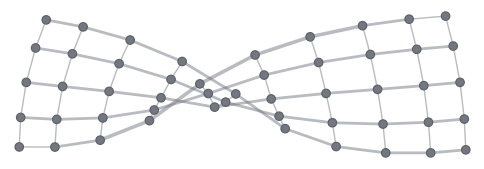

tensor(0.3495, dtype=torch.float64, grad_fn=<MulBackward0>)

In [28]:
state = circuit_tnf.get_state()
config = torch.tensor([0,1,0,1,0,1,0,1,0,1], dtype=torch.int8)
amp = state.get_amp(config)
amp.draw()
amp.contract()

In [29]:
circuit_tnf(config)

tensor([0.3495], dtype=torch.float64, grad_fn=<StackBackward0>)

In [30]:
circuit_tnf.num_params

2600

In [28]:
import torch
from vmc_torch.sampler import MetropolisExchangeSamplerSpinless
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import SGD, SR, DecayScheduler
from vmc_torch.VMC import VMC
from vmc_torch.hamiltonian_torch import spin_Heisenberg_chain_torch
from vmc_torch.torch_utils import SVD,QR
from vmc_torch.experiment.tn_model import circuit_TNF
from funcs import *

import os
os.environ["OPENBLAS_NUM_THREADS"] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ["OMP_NUM_THREADS"] = '1'
from mpi4py import MPI
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()


L = 10
D = 6
H = spin_Heisenberg_chain_torch(L, J=1.0, pbc=False, total_sz=0)
ham_quimb = qtn.ham_1d_heis(L, j=1.0, cyclic=False)
ham_quimb.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float64))
graph = H.graph
hilbert = H.hilbert
dtype = torch.float64

exp_all_states = list(enumerate_bitstrings(L))
projected_states = torch.tensor(hilbert.all_states())
projected_states_tuple = [tuple(state.tolist()) for state in projected_states]

import pickle
su_params, su_skeleton = pickle.load(open(f"circuitTNF_heis_L{L}_D{D}_su_state.pkl", "rb"))
su_mps = qtn.unpack(su_params, su_skeleton)

model = circuit_TNF(
    su_mps,
    ham_quimb,
    trotter_tau=0.1,
    depth=2,
    max_bond=6,
    dtype=torch.float64,
    from_which='yboth',
)

# VMC sample size
N_samples = int(4)
N_samples = N_samples - N_samples % SIZE + SIZE
if (N_samples/SIZE)%2 != 0:
    N_samples += SIZE

# Set up optimizer and scheduler
learning_rate = 1e-1
scheduler = DecayScheduler(init_lr=learning_rate, decay_rate=0.9, patience=50, min_lr=1e-4)
optimizer = SGD(learning_rate=learning_rate)
sampler = MetropolisExchangeSamplerSpinless(H.hilbert, graph, N_samples=N_samples, burn_in_steps=1, reset_chain=False, random_edge=True, dtype=dtype, equal_partition=True)
variational_state = Variational_State(model, hi=H.hilbert, sampler=sampler, dtype=dtype)
preconditioner = SR(dense=False, exact=True if sampler is None else False, use_MPI4Solver=True, diag_eta=0.05, iter_step=1e5, dtype=dtype)
# Set up VMC
vmc = VMC(hamiltonian=H, variational_state=variational_state, optimizer=optimizer, preconditioner=preconditioner, scheduler=scheduler)

# if __name__ == "__main__":
#     energy_dict = variational_state.expect(H)
amps = model(projected_states)
amp_dict = dict(zip(projected_states_tuple, amps.detach().numpy()))
state_vec = state_vector_from_amps(amp_dict, L)

In [29]:
import quimb as qu
ham_quimb = qu.ham_heis(L, j=1.0)
print(qu.groundenergy(ham_quimb))
ham_matrix = ham_quimb.toarray()

(state_vec@np.matmul(ham_matrix, state_vec))/(state_vec @ state_vec)

-4.258035207282882


np.complex128(-4.2572011263516485+0j)

In [33]:
su_mps.compute_local_expectation_exact(ham.terms, normalized=True)

tensor(-4.2548, dtype=torch.float64)